In [19]:
#!conda --version
#!pip install flaml[automl]
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from flaml import AutoML
import sklearn
from sklearn.ensemble import RandomForestRegressor as RF
import pickle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from flaml.automl.data import get_output_from_log

print("FLAML version: {}".format(AutoML.__version__))
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("SKLearn version: {}".format(sklearn.__version__))
print("Seaborn version: {}".format(sns.__version__))

FLAML version: 2.3.5
Numpy version: 1.26.4
Pandas version: 2.2.2
SKLearn version: 1.4.2
Seaborn version: 0.13.2


In [20]:
# The data catalogue is stored as a CSV file. Here we read it with pandas.

data_path1 = 'D:/A_sem2/ERP/Simulation/new_lhs/lhs_exps.csv' # Change this to the path of the data file on your system
data_path2 = 'D:/A_sem2/ERP/Code/HIA_max_min_mean.xlsx' # Change this to the path of the data file on your system
# Load the data
df1 = pd.read_csv(data_path1, index_col=0, parse_dates=True)
df1 = df1.drop(columns=['ALB_ROOF_DIF', 'ALB_IMPROAD_DIF', 'ALB_PERROAD_DIF', 'ALB_WALL_DIF','WIND_HGT_CANYON'])
df2 = pd.read_excel(data_path2, parse_dates=True)
df1 = pd.concat([df1, df2.iloc[:, 2]], axis=1) # 将要df2中的第一个变量合并到df1中（放到最后一列）
display(df1.head(10))
#display(df2.head(10))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9808\1650679715.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1 = pd.read_csv(data_path1, index_col=0, parse_dates=True)


KeyboardInterrupt: 

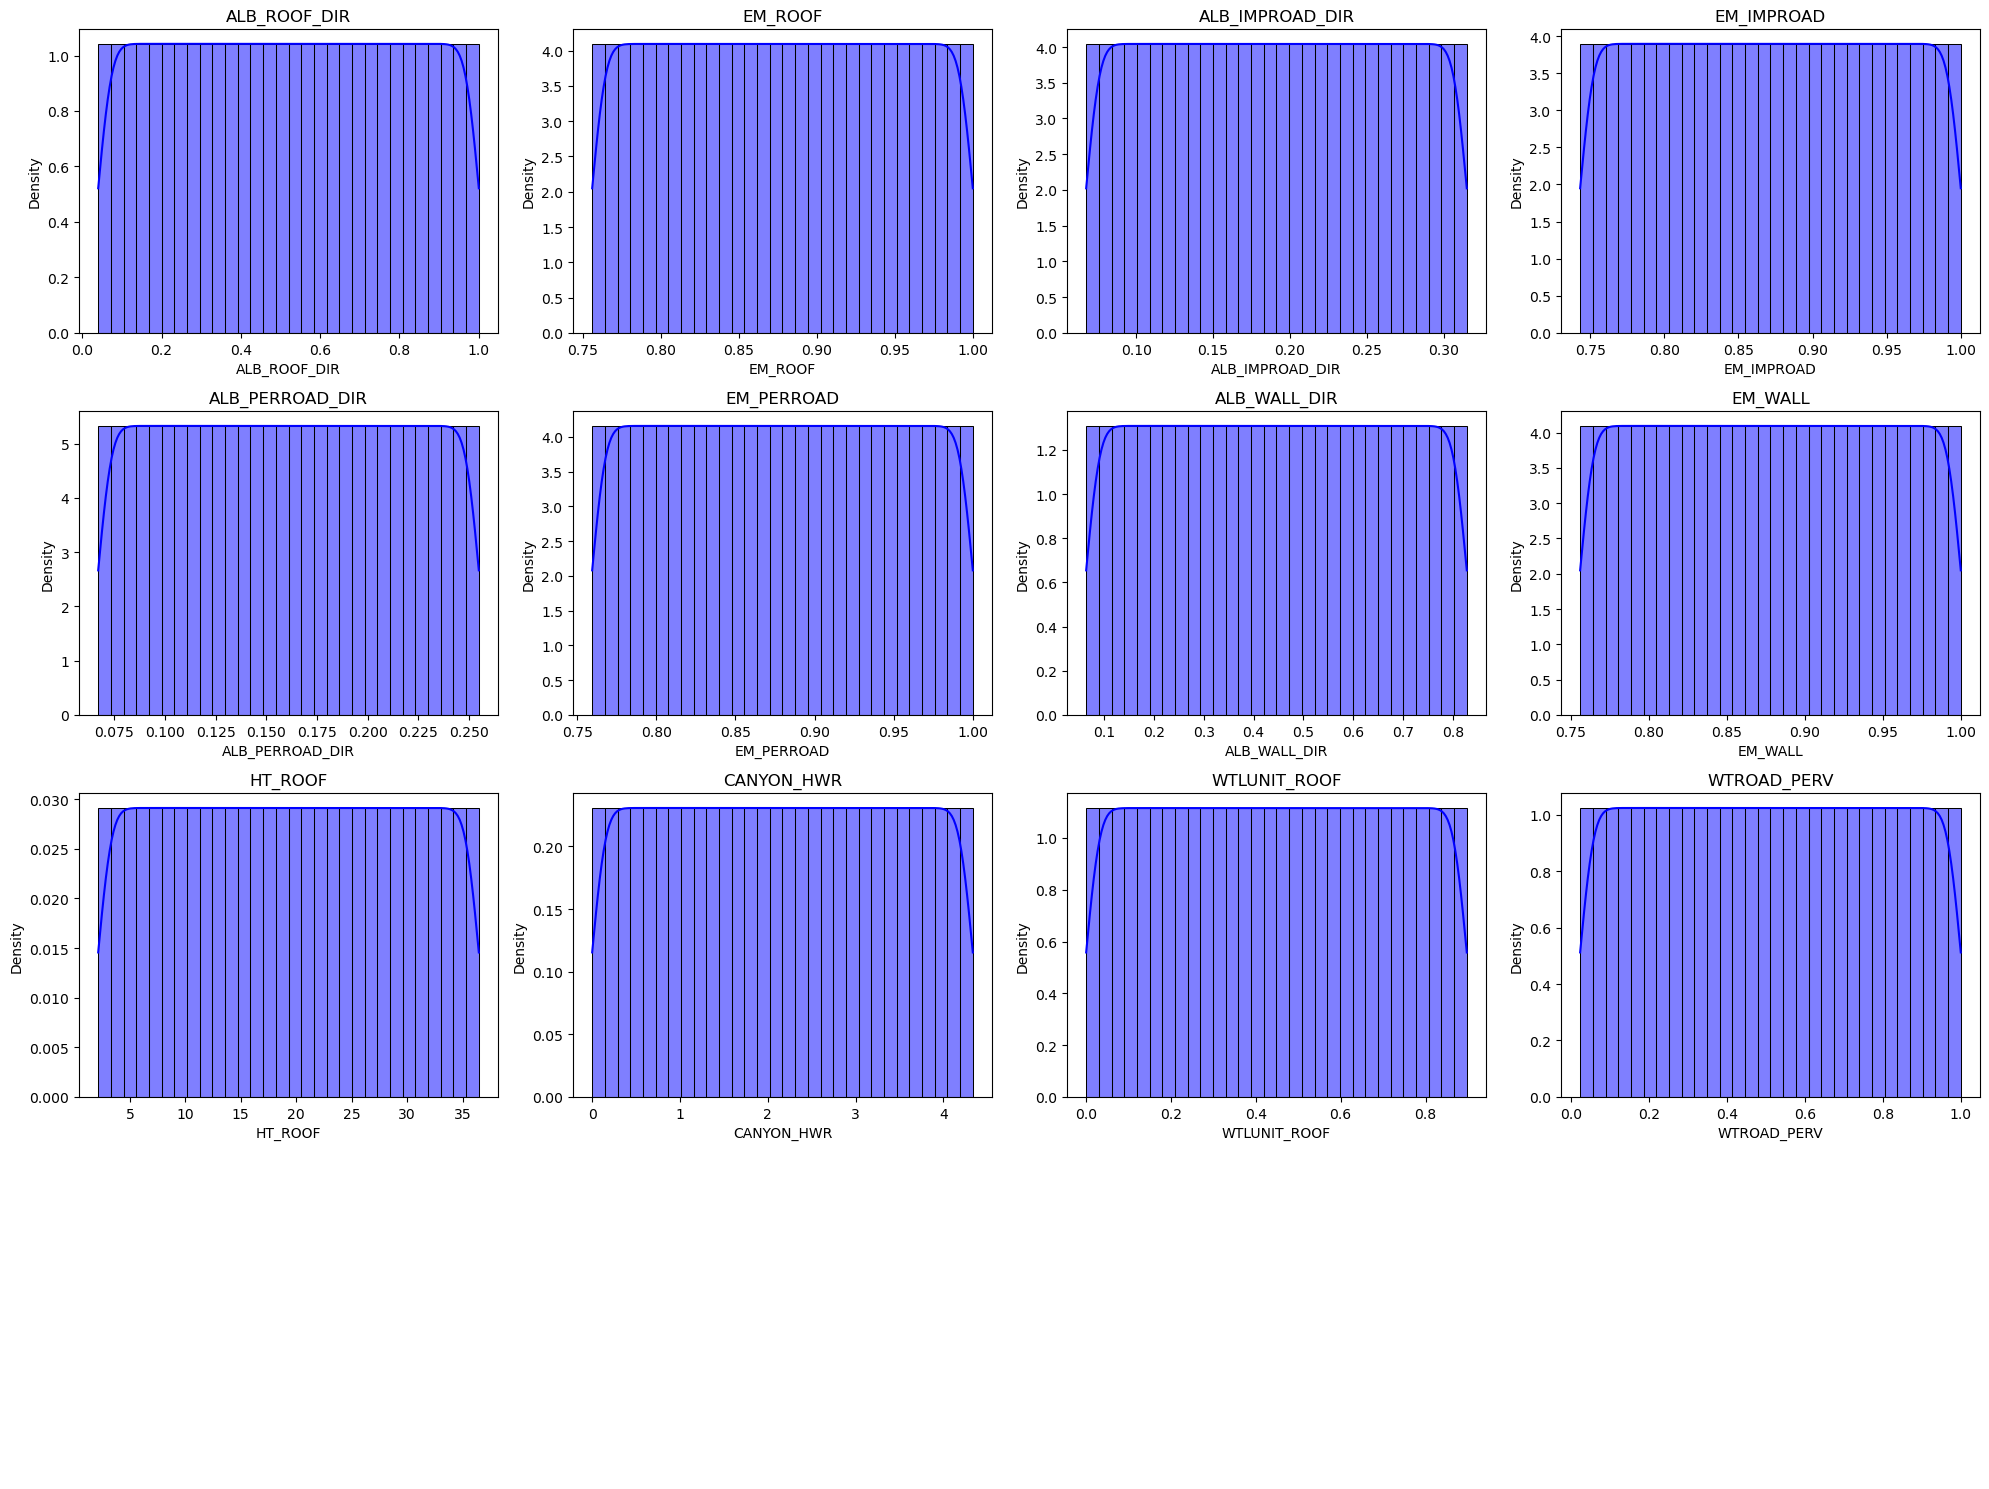

In [ ]:
# 绘制13个变量的概率密度图

# 你需要绘制的13个变量名列表（对应df1列名）
var_names = [
    'ALB_ROOF_DIR',
    'EM_ROOF',
    'ALB_IMPROAD_DIR',
    'EM_IMPROAD',
    'ALB_PERROAD_DIR',
    'EM_PERROAD',
    'ALB_WALL_DIR',
    'EM_WALL',
    # 'WIND_HGT_CANYON',
    'HT_ROOF',
    'CANYON_HWR',
    'WTLUNIT_ROOF',
    'WTROAD_PERV'
]

# 创建画布，4行4列，留出1个空白子图
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(var_names):
        data = df1[var_names[i]].dropna()  # 如果有NaN，去掉
        sns.histplot(data, kde=True, ax=ax, color='b', stat='density', bins=30)
        ax.set_title(var_names[i])
    else:
        ax.axis('off')  # 多余空白子图隐藏

plt.tight_layout()
plt.show()

In [ ]:
display(df1.describe().T)


,count,mean,std,min,25%,50%,75%,max
ALB_ROOF_DIR,100000.0,0.520180,0.277026,0.040366,0.280275,0.520180,0.760085,0.999993
EM_ROOF,100000.0,0.877924,0.070481,0.755849,0.816887,0.877924,0.938961,1.000000
ALB_IMPROAD_DIR,100000.0,0.191169,0.071391,0.067518,0.129344,0.191168,0.252994,0.314819
EM_IMPROAD,100000.0,0.871614,0.074124,0.743230,0.807422,0.871614,0.935807,0.999998
ALB_PERROAD_DIR,100000.0,0.160972,0.054188,0.067116,0.114044,0.160971,0.207900,0.254826
EM_PERROAD,100000.0,0.879705,0.069453,0.759411,0.819558,0.879705,0.939851,0.999999
ALB_WALL_DIR,100000.0,0.446000,0.220549,0.064002,0.255000,0.446003,0.636997,0.827997
EM_WALL,100000.0,0.877924,0.070481,0.755850,0.816886,0.877924,0.938962,0.999998
HT_ROOF,100000.0,19.303164,9.913056,2.133453,10.718386,19.303182,27.888055,36.472930
CANYON_HWR,100000.0,2.168296,1.251635,0.000445,1.084359,2.168293,3.252235,4.336177


In [ ]:
train_num = int(0.8 * len(df1)) # 计算出数据集中前80%的数量，作为训练集的样本数量
train, test = df1.iloc[:train_num], df1.iloc[train_num:] # 使用iloc按行索引进行切片，前80%赋给train，后20%赋给test
train

,ALB_ROOF_DIR,EM_ROOF,ALB_IMPROAD_DIR,EM_IMPROAD,ALB_PERROAD_DIR,EM_PERROAD,ALB_WALL_DIR,EM_WALL,HT_ROOF,CANYON_HWR,WTLUNIT_ROOF,WTROAD_PERV,HIA_mean
0,0.867109,0.990241,0.151921,0.897831,0.103656,0.937855,0.629264,0.993075,20.309085,1.124637,0.042698,0.355400,26.370188
1,0.689149,0.837570,0.183997,0.856856,0.129165,0.764162,0.795071,0.957548,26.415594,1.685905,0.788026,0.364434,26.021769
2,0.440487,0.904625,0.216487,0.883614,0.202678,0.760849,0.095133,0.791472,23.112687,3.775621,0.214968,0.589368,26.372889
3,0.996312,0.805200,0.193108,0.979353,0.201636,0.955750,0.321593,0.983677,8.862520,0.005116,0.400565,0.348086,24.995977
4,0.074822,0.997615,0.124448,0.820825,0.235898,0.891563,0.740665,0.978814,34.097124,1.006281,0.105618,0.840065,25.583542
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.357790,0.886958,0.300047,0.851810,0.215798,0.819100,0.266898,0.941220,21.132038,2.499865,0.190244,0.775949,26.320459
79996,0.922056,0.777644,0.141380,0.745530,0.232554,0.780078,0.128955,0.783014,17.670039,0.021876,0.609921,0.195292,25.506594
79997,0.325904,0.960300,0.288180,0.750185,0.162091,0.942221,0.644823,0.950538,28.071574,3.812748,0.018528,0.733491,25.449120
79998,0.417894,0.860011,0.109574,0.866886,0.140436,0.931690,0.516862,0.891222,26.630194,3.292091,0.700903,0.477045,26.944237


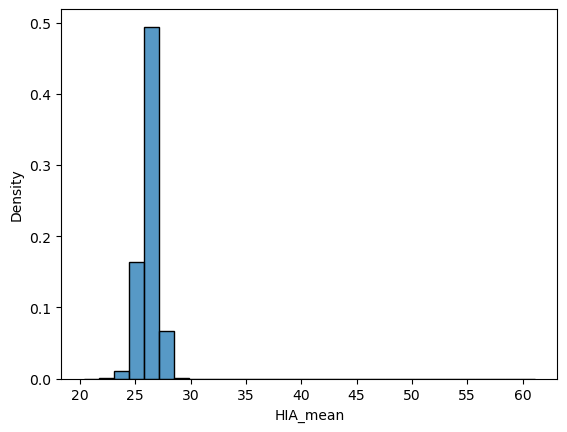

In [ ]:
sns.histplot(data=df1, x='HIA_mean', bins=30, kde=False, stat='density')
plt.show()

In [ ]:
# =============exploratory data analysis================
# =============trainning data================
display(train.describe().T)
display(train.info())

# =============test data================
display(test.describe().T)
display(test.info())


,count,mean,std,min,25%,50%,75%,max
ALB_ROOF_DIR,80000.0,0.519945,0.276894,0.040366,0.280857,0.519916,0.759878,0.999993
EM_ROOF,80000.0,0.877889,0.070376,0.755849,0.816921,0.877983,0.938615,1.000000
ALB_IMPROAD_DIR,80000.0,0.191142,0.071295,0.067518,0.129604,0.191013,0.252829,0.314819
EM_IMPROAD,80000.0,0.871583,0.074113,0.743230,0.807529,0.871668,0.935728,0.999995
ALB_PERROAD_DIR,80000.0,0.160987,0.054157,0.067116,0.114136,0.160991,0.207863,0.254826
EM_PERROAD,80000.0,0.879739,0.069426,0.759411,0.819630,0.879701,0.939910,0.999999
ALB_WALL_DIR,80000.0,0.446270,0.220410,0.064002,0.255797,0.446541,0.637101,0.827997
EM_WALL,80000.0,0.877902,0.070501,0.755851,0.816882,0.877936,0.938908,0.999998
HT_ROOF,80000.0,19.310484,9.923235,2.133453,10.683063,19.313849,27.916400,36.472930
CANYON_HWR,80000.0,2.166486,1.252202,0.000445,1.083184,2.165793,3.251737,4.336177


<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 0 to 79999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ALB_ROOF_DIR     80000 non-null  float64
 1   EM_ROOF          80000 non-null  float64
 2   ALB_IMPROAD_DIR  80000 non-null  float64
 3   EM_IMPROAD       80000 non-null  float64
 4   ALB_PERROAD_DIR  80000 non-null  float64
 5   EM_PERROAD       80000 non-null  float64
 6   ALB_WALL_DIR     80000 non-null  float64
 7   EM_WALL          80000 non-null  float64
 8   HT_ROOF          80000 non-null  float64
 9   CANYON_HWR       80000 non-null  float64
 10  WTLUNIT_ROOF     80000 non-null  float64
 11  WTROAD_PERV      80000 non-null  float64
 12  HIA_mean         80000 non-null  float64
dtypes: float64(13)
memory usage: 8.5 MB


None

,count,mean,std,min,25%,50%,75%,max
ALB_ROOF_DIR,20000.0,0.521122,0.277554,0.040422,0.278029,0.521229,0.761007,0.999966
EM_ROOF,20000.0,0.878064,0.070901,0.755865,0.816783,0.877609,0.940517,0.999989
ALB_IMPROAD_DIR,20000.0,0.191274,0.071775,0.067528,0.128336,0.191834,0.253563,0.314806
EM_IMPROAD,20000.0,0.871737,0.074169,0.743231,0.807077,0.871442,0.936075,0.999998
ALB_PERROAD_DIR,20000.0,0.160913,0.054313,0.067119,0.113714,0.160861,0.208043,0.254817
EM_PERROAD,20000.0,0.879569,0.069560,0.759501,0.819210,0.879721,0.939594,0.999995
ALB_WALL_DIR,20000.0,0.444920,0.221106,0.064030,0.251881,0.444128,0.636648,0.827920
EM_WALL,20000.0,0.878013,0.070402,0.755850,0.816948,0.877888,0.939189,0.999976
HT_ROOF,20000.0,19.273883,9.872430,2.136065,10.851467,19.257810,27.800664,36.470165
CANYON_HWR,20000.0,2.175539,1.249368,0.000652,1.091539,2.177988,3.255210,4.335952


<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 80000 to 99999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ALB_ROOF_DIR     20000 non-null  float64
 1   EM_ROOF          20000 non-null  float64
 2   ALB_IMPROAD_DIR  20000 non-null  float64
 3   EM_IMPROAD       20000 non-null  float64
 4   ALB_PERROAD_DIR  20000 non-null  float64
 5   EM_PERROAD       20000 non-null  float64
 6   ALB_WALL_DIR     20000 non-null  float64
 7   EM_WALL          20000 non-null  float64
 8   HT_ROOF          20000 non-null  float64
 9   CANYON_HWR       20000 non-null  float64
 10  WTLUNIT_ROOF     20000 non-null  float64
 11  WTROAD_PERV      20000 non-null  float64
 12  HIA_mean         20000 non-null  float64
dtypes: float64(13)
memory usage: 2.1 MB


None

### Define the features and target variable

In [ ]:
feature_ls = df1.columns.tolist()
feature_ls.remove('HIA_mean')
print('The features are:', feature_ls)

label = 'HIA_mean'
print('The label is:', label)

The features are: ['ALB_ROOF_DIR', 'EM_ROOF', 'ALB_IMPROAD_DIR', 'EM_IMPROAD', 'ALB_PERROAD_DIR', 'EM_PERROAD', 'ALB_WALL_DIR', 'EM_WALL', 'HT_ROOF', 'CANYON_HWR', 'WTLUNIT_ROOF', 'WTROAD_PERV']
The label is: HIA_mean


### Train the model

In [ ]:
# ====== train model ======
time_budget = 500  # total running time in seconds

# specify the estimator list
estimator_list = ['lgbm', 'xgboost','rf']

# create the AutoML object
automl = AutoML()

# specify the automl settings
automl_settings = {
    "time_budget": time_budget,  # in seconds
    "estimator_list":estimator_list, # estimators
    "metric": 'rmse', # metric参数是用来指定模型评估和搜索时优化的目标指标。AutoML将基于RMSE进行模型选择和超参搜索
    "task": 'regression', # 指定进行回归任务。另外还有分类任务等
    "log_file_name": "log.log"
}

# fit the model
automl.fit(train[feature_ls], train[label], **automl_settings) #,max_iter=2
print(automl.model.estimator)

[flaml.automl.logger: 08-09 13:48:50] {1752} INFO - task = regression
[flaml.automl.logger: 08-09 13:48:50] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 08-09 13:48:50] {1862} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 08-09 13:48:50] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost']
[flaml.automl.logger: 08-09 13:48:50] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 08-09 13:48:50] {2417} INFO - Estimated sufficient time budget=3913s. Estimated necessary time budget=4s.
[flaml.automl.logger: 08-09 13:48:50] {2466} INFO -  at 0.7s,	estimator lgbm's best error=0.6668,	best estimator lgbm's best error=0.6668
[flaml.automl.logger: 08-09 13:48:50] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-09 13:48:50] {2466} INFO -  at 1.1s,	estimator lgbm's best error=0.6668,	best estimator lgbm's best error=0.6668
[flaml.automl.logger: 08-09 13:48:50] {2282} INFO - iteration 2, current learner lgbm
[flam

In [ ]:
print("Best estimator:", automl.model.estimator)
print("Best validation RMSE:", automl.best_loss)

Best estimator: LGBMRegressor(colsample_bytree=0.7750396473588606,
              learning_rate=0.09923336893317476, max_bin=1023,
              min_child_samples=7, n_estimators=3105, n_jobs=-1, num_leaves=81,
              reg_alpha=0.014094603319861362, reg_lambda=0.026152243630780125,
              verbose=-1)
Best validation RMSE: 0.17767621832636984


### Evaluate the final model performance

In [ ]:
print('Trainning data')
y_train = train[label]
y_pred_train = automl.predict(train[feature_ls])

rmse = mean_squared_error(y_train, y_pred_train, squared=False)# 使用train里面的数据计算得到的rmse
r2 = r2_score(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
print('RMSE:', rmse)
print('R2:', r2)
print('MAE:', mae)

Trainning data


RMSE: 0.009186562051978063
R2: 0.9998566633538805
MAE: 0.006798197316569624


d:\python_Anaconda_install\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


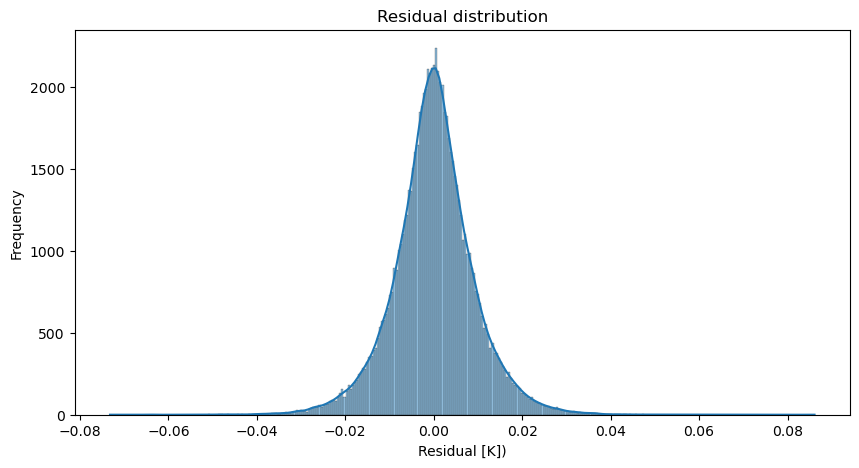

In [ ]:
# ====== plot the residual ======
residual = train[label] - y_pred_train
plt.figure(figsize=(10, 5))
sns.histplot(residual, kde=True)
plt.ylabel('Frequency')
plt.xlabel('Residual [K])')
plt.title('Residual distribution')
plt.show()

In [ ]:
# save the model
with open('ERP_automl_model_HIAmean.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

Check the logs

In [ ]:
print(automl.best_estimator)

print(automl.best_config)

print(automl.best_config_train_time)

print(automl.best_iteration)

print(automl.best_loss) # 这里用的是RMSE（前面设定的metrics），这里用的是test里的数据计算的RMSE

print(automl.time_to_find_best_model)

print(automl.config_history)

lgbm
{'n_estimators': 3105, 'num_leaves': 81, 'min_child_samples': 7, 'learning_rate': 0.09923336893317476, 'log_max_bin': 10, 'colsample_bytree': 0.7750396473588606, 'reg_alpha': 0.014094603319861362, 'reg_lambda': 0.026152243630780125}
15.863354206085205
57
0.17767621832636984
233.76900124549866
{0: ('lgbm', {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}, 0.6619691848754883), 2: ('lgbm', {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 12, 'learning_rate': 0.26770501231052046, 'log_max_bin': 7, 'colsample_bytree': 1.0, 'reg_alpha': 0.001348364934537134, 'reg_lambda': 1.4442580148221913}, 1.461066722869873), 4: ('lgbm', {'n_estimators': 12, 'num_leaves': 4, 'min_child_samples': 9, 'learning_rate': 0.7260594590615893, 'log_max_bin': 9, 'colsample_bytree': 0.9285002286474459, 'reg_alpha': 0.0036840681931986645, 'reg_lambda': 0.75324805057

Check the learning curve from the log file

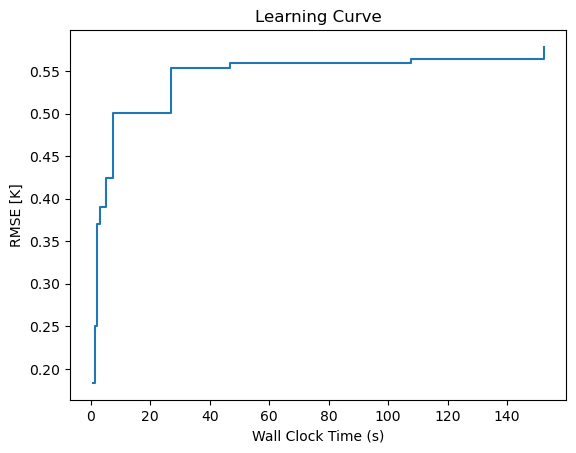

([0.6619691848754883,
  1.461066722869873,
  2.229426622390747,
  3.2347097396850586,
  5.225406646728516,
  7.5288708209991455,
  27.07214117050171,
  46.7576265335083,
  107.52681136131287,
  152.31611967086792,
  233.76900124549866],
 [0.6668331289164865,
  0.5626710904448521,
  0.3971433067304979,
  0.37147524357722306,
  0.3318174673578163,
  0.24983536205991239,
  0.19897801605609333,
  0.19402509421756559,
  0.19019406224350982,
  0.1777983570790184,
  0.17767621832636984],
 [0.6668331289164865,
  0.5626710904448521,
  0.3971433067304979,
  0.37147524357722306,
  0.3318174673578163,
  0.24983536205991239,
  0.19897801605609333,
  0.19402509421756559,
  0.19019406224350982,
  0.1777983570790184,
  0.17767621832636984],
 [{'Current Learner': 'lgbm',
   'Current Sample': 80000,
   'Current Hyper-parameters': {'n_estimators': 4,
    'num_leaves': 4,
    'min_child_samples': 20,
    'learning_rate': 0.09999999999999995,
    'log_max_bin': 8,
    'colsample_bytree': 1.0,
    'reg_alph

In [ ]:
from flaml.automl.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(filename=automl_settings["log_file_name"], time_budget=200)

plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("RMSE [K]")
plt.step(time_history, 1- np.sqrt(np.array(best_valid_loss_history)), where="post")
plt.show()
d = get_output_from_log(filename=automl_settings["log_file_name"], time_budget=500)
display(d)

In [ ]:
# =============load model================
automl = pickle.load(open('ERP_automl_model_HIAmean.pkl', 'rb'))

In [ ]:
# evaluate the final model performance
y_test = test[label]
y_pred_test = automl.predict(test[feature_ls])
print("testing rmse:", mean_squared_error(y_true=y_test, y_pred=y_pred_test, squared=False))
print("testing r2:", r2_score(y_true=y_test, y_pred=y_pred_test))
print("testing mae:", mean_absolute_error(y_true = y_test, y_pred = y_pred_test))

testing rmse: 0.19277760686414616
testing r2: 0.935774732459405
testing mae: 0.046120102109186725


d:\python_Anaconda_install\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
### 将y_test_real写成nc格式文件
# import xarray as xr
# display(y_pred_test.shape)
# ds_test_klaml = xr.Dataset(
#     {
#         "y_pred": (("200000"), y_pred_test)
#     },
# )
# ds_test_klaml.to_netcdf("ERP_ds_test_klaml.nc")# 
# print("NetCDF 文件保存成功！")

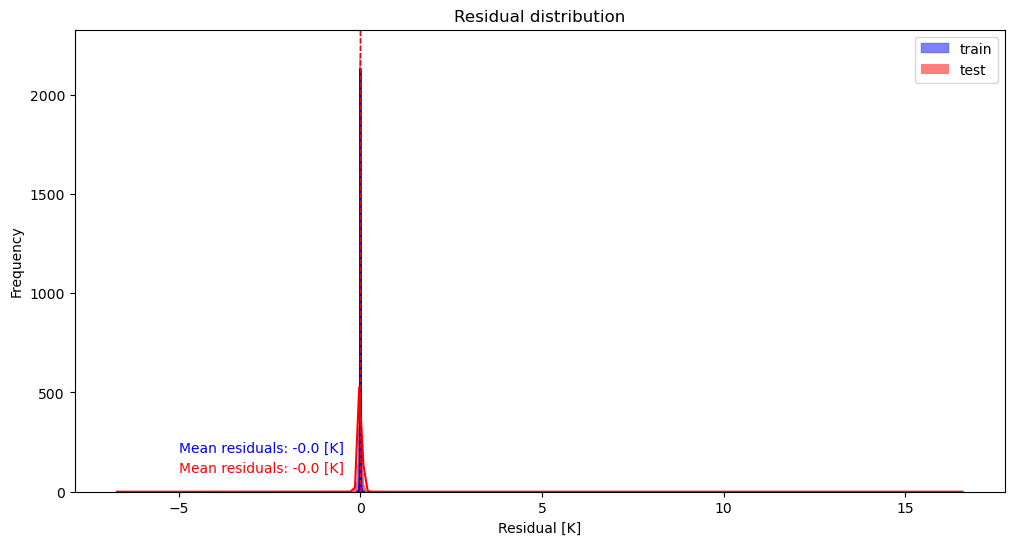

In [ ]:
### example plotting

residuals_train = train[label] - y_pred_train
residuals_test = test[label] - y_pred_test

plt.figure(figsize=(12, 6))
sns.histplot(residuals_train, kde=True, color='blue', label='train')# , binwidth = 0.1
sns.histplot(residuals_test, kde=True, color='red', label='test')

mean_train = residuals_train.mean()
mean_test = residuals_test.mean()

plt.axvline(mean_train, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_test, color='red', linestyle='dashed', linewidth=1)

plt.text(-5, 200, f'Mean residuals: {mean_train.round(2)} [K]', rotation=0, color='blue')
plt.text(-5, 100, f'Mean residuals: {mean_test.round(2)} [K]', rotation=0, color='red')

plt.ylabel('Frequency')
plt.xlabel('Residual [K]')
plt.title('Residual distribution')
plt.legend()
plt.show()

### Feature Importance

array([ 8575,  4468,  3084,  2665,  3138,  2266,  6156,  2795,  3765,
         872, 11122,  9611,  7188])

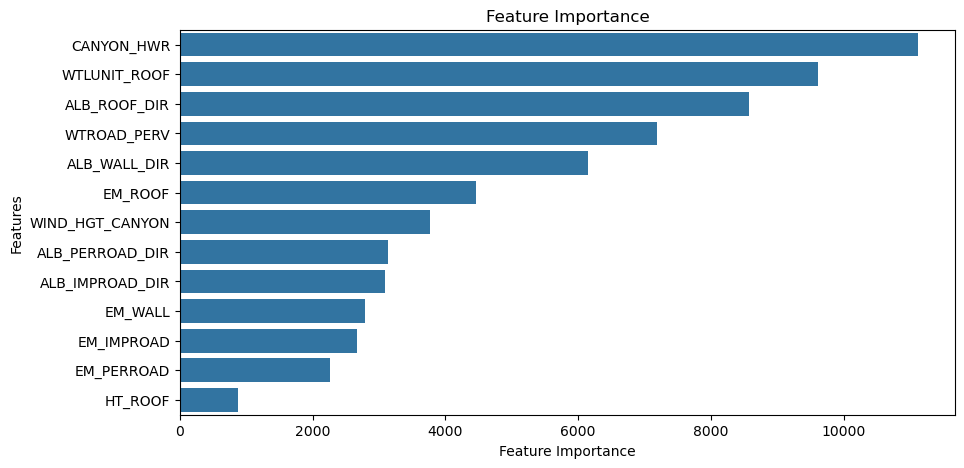

In [ ]:
# =========== feature importance =========== 

# only when the model is tree-based, we can get the feature importance directly from the model
fi = automl.model.estimator.feature_importances_
display(fi)
# 排序
# 把重要性和特征名放到DataFrame中
df_fi = pd.DataFrame({'feature': feature_ls, 'importance': fi})
# 按importance降序排序
df_fi = df_fi.sort_values(by='importance', ascending=False)

# plot
plt.figure(figsize=(10, 5))
sns.barplot(x='importance', y='feature', data=df_fi)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

### Using Shap for Feature IMportance

In [ ]:
## SHAPELY importances
# !pip install shap==0.39.0
# =========== shapley ===========
import shap


d:\python_Anaconda_install\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


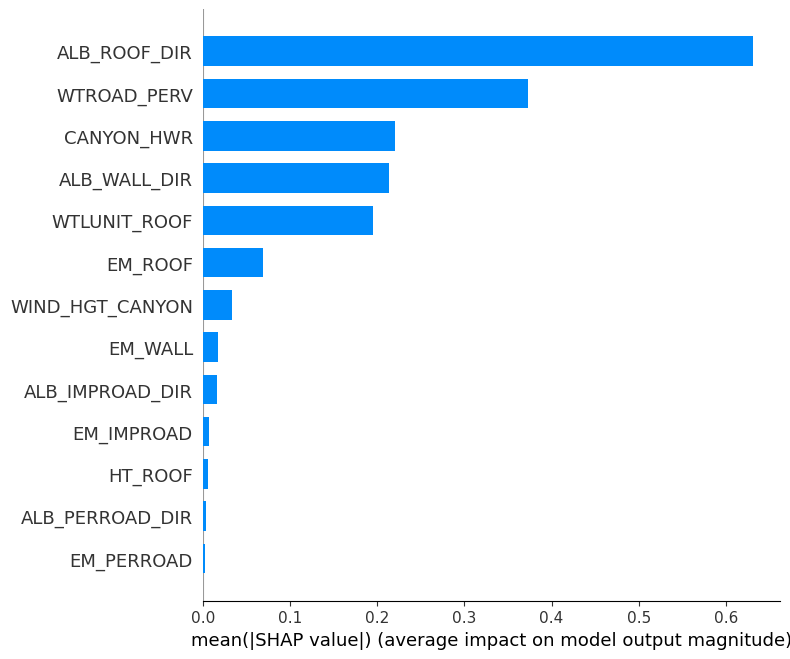

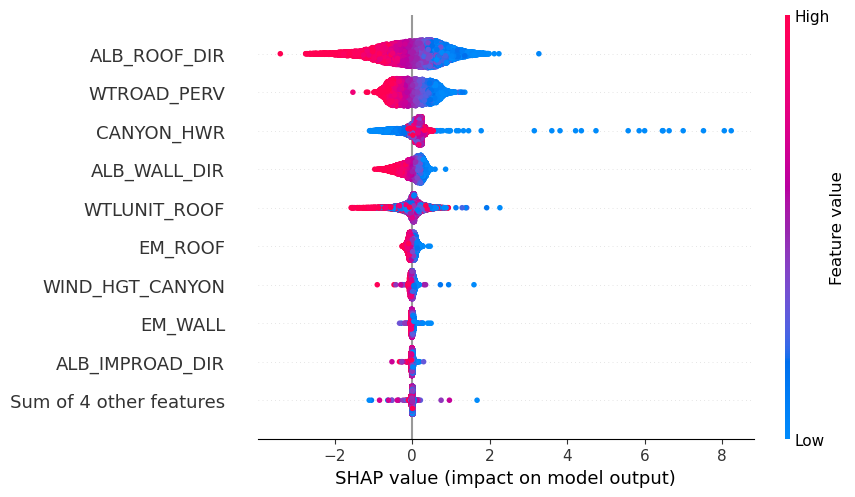

.values =
array([[-0.81760612, -0.14459238, -0.01340405, ...,  0.15799908,
        -0.21525361, -0.34493482],
       [ 0.6941245 , -0.0369291 ,  0.02280302, ..., -0.53884924,
        -0.25725953, -0.47829221],
       [ 0.95704117,  0.09645029, -0.00385729, ...,  0.11457418,
         0.17169367, -0.20914088],
       ...,
       [-0.08329267,  0.13661544,  0.00637065, ...,  0.21570567,
         0.12966198, -0.4601647 ],
       [-1.02915304, -0.02442234, -0.02453642, ...,  0.09526636,
         0.50072394,  0.49986539],
       [-0.36925842,  0.02190473,  0.04903546, ..., -0.02024412,
         0.1637076 ,  0.79353237]])

.base_values =
array([26.50349614, 26.50349614, 26.50349614, ..., 26.50349614,
       26.50349614, 26.50349614])

.data =
array([[0.73131079, 0.96219736, 0.2939577 , ..., 4.14562028, 0.80629098,
        0.80575082],
       [0.07461911, 0.92706324, 0.13730733, ..., 0.32959771, 0.20920231,
        0.74136289],
       [0.1833236 , 0.8050339 , 0.21080098, ..., 1.81830156, 0.606

In [ ]:

# explain the model's predictions using SHAP
explainer = shap.Explainer(automl.model.estimator)
shap_values_klaml = explainer(test[feature_ls])
shap.summary_plot(shap_values_klaml, plot_type='bar')
# visualize the training set predictions
shap.plots.beeswarm(shap_values_klaml)
print(shap_values_klaml)


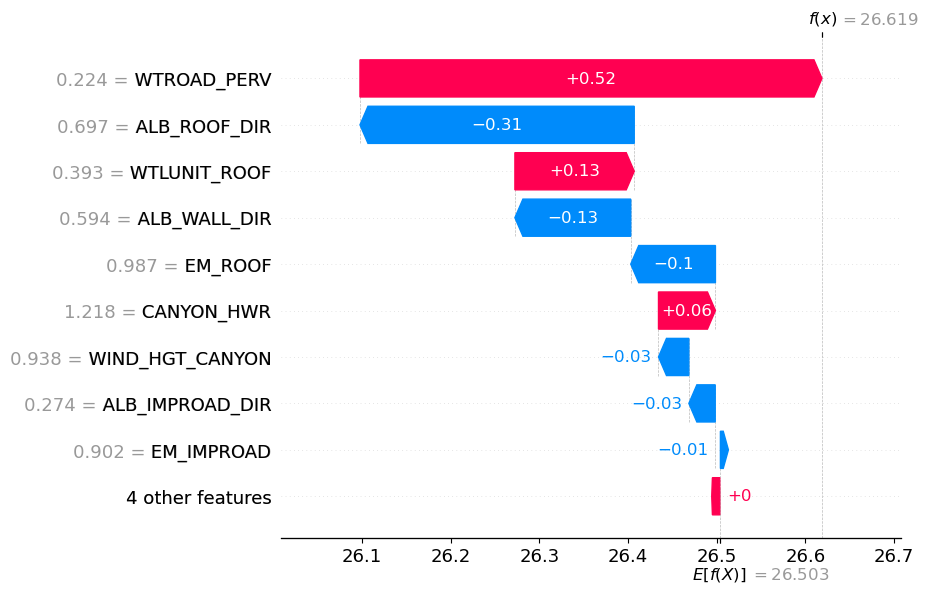

In [ ]:
# visualize the first prediction's explanation
shap.initjs() # shap.initjs() 负责在Jupyter Notebook等环境初始化JavaScript支持，用于后续的交互式图形显示
shap.plots.waterfall(shap_values_klaml[1007])